# Helicity for different systems and FF modifications - LOURDES

Do some analysis of the helicities.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import mdtraj as md
import seaborn as sns
#from scipy.stats import gaussian_kde
import pandas as pd
from Bio.SeqUtils import IUPACData

Some other libraries we could use to add some information to the analysis

In [3]:
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools
import mdtraj.testing

Here I define some functions. I do not use all of the in this notebook. Just for you to see.

In [4]:
def calc_helicity(dirname, temp=1,equil=0):
    """
    Calculate the helicity from a trajectory
    """
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    #print (t)
    ss = md.compute_dssp(t)
    return ss =='H', ss =='C'

def helicity (t):
    ss = md.compute_dssp(t,simplified=True)
    ssh = (ss=='H').astype(np.float)
    ssc = (ss=='C').astype(np.float)
    t_helix = t[np.all(ssh[:,6:10]>0,1)]
    return t_helix

def get_residues(dirname):
    """
    Return the residue list from the topology
    """
    topname = os.path.join(dirname, 'prot.pdb')
    t = md.load(topname, stride=1)
    return list(t.top.residues)

def calc_H_bonds(dirname, temp=1,equil=0):
    """
    Calculate the H_bonds between Q1 and L1.
    In fact this just returns the distance not the H-bond.
    """
    from itertools import product
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    print (t)
    #These are the potential donor atom names.
    #Selecting the hydrogens of Q1
    donors = t.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
    if donors.size==0: return np.array([9999.])
    #Selecting the oxigen of L1
    acceptor = t.topology.select('residue 7 and name O')
    pairs = list(product(donors, acceptor))
    d = md.compute_distances(t, pairs)
    #print (d)
    #We take the shortest distance
    d = d.min(1)
    #print (d)
    d *= 10 #to angstroms
    return d

def calc_chis(dirname, temp=1,equil=5000):
    """
    Calculate the Chi1, chi2, chi3 of residue Q1 or equivalent.
    """
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    r11 = t.topology.select('residue 11')
    t = t.atom_slice(r11)
    chi1 = md.compute_chi1(t)[1]
    chi2 = md.compute_chi2(t)[1]
    chi3 = md.compute_chi3(t)[1]
    return np.hstack([chi1,chi2,chi3])

def chis11_21(dirname, temp=1,equil=5000):
    """
    Calculate the Chi1, chi2, chi3 of residue Q11 vs Q20 
    """
    topname = os.path.join(dirname, 'prot.pdb')
    trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
    t = md.load(trajname, top=topname, stride=1)
    t = t[equil:]
    t.remove_solvent(inplace=True)
    r11 = t.topology.select('residue 11')
    tt = t.atom_slice(r11)
    chi1 = md.compute_chi1(tt)[1]
    chi2 = md.compute_chi2(tt)[1]
    chi3 = md.compute_chi3(tt)[1]
    r21 = t.topology.select('residue 21')
    # Esto no seria 'residue 20?'
    tt = t.atom_slice(r21)
    chi11 = md.compute_chi1(tt)[1]
    chi22 = md.compute_chi2(tt)[1]
    chi33 = md.compute_chi3(tt)[1]
    data = np.hstack([chi1,chi2,chi3, chi11, chi22, chi33])
    data *= 180/np.pi
    return pd.DataFrame(data, columns=['chi1_11','chi2_11','chi3_11','chi1_20','chi2_20','chi3_20'])

def plot_helicity(helix, residues, blocks=5, equil=0, **kwargs):
    """
    Plot the helicity from an array of (N,M) of calculated helicities 
    """
    #Remove equilibration
    helix = helix[equil:]
    n_frames = helix.shape[0]
    step = n_frames//blocks
    values = [helix[i*step:(i+1)*step].mean(0) for i in range(blocks)]
    #df=pd.DataFrame(values, columns=[s+str(i) for i,s in enumerate('KKPGASLLLL'+12*'Q'+'KK')]).T
    #df=pd.DataFrame(values, columns=[s for s in 'KKPGASLLLL'+12*'Q'+'KK']).T
    df=pd.DataFrame(values).T
    df =df.unstack().reset_index()
    df.columns=['repetion', 'residue', 'helicity']
    ax=sns.lineplot(x='residue', y='helicity', data=df, sort=False, **kwargs)
    #plt.xticks(np.arange(helix[name].shape[1]), 'KKPGASLLLL'+12*'Q'+'KK')
    #ax.set_xticks(np.arange(helix.shape[1]) )
    #ax.set_xticklabels('KKPGASLLLL'+12*'Q'+'KK')
    plt.xlabel('Residue',fontsize=20)
    plt.ylabel('Average Helicity',fontsize=20)
    ax.grid(True)
    plt.legend(fontsize=20)
    plt.ylim(None, 1.)
    ticks=''.join([IUPACData.protein_letters_3to1[r.name.title()] for r in residues])
    plt.xticks(np.arange(helix.shape[1]), ticks)
    
def Q1_helicity(helix, residues, blocks=5, equil=0):
    helix = helix[equil:]
    n_frames = helix.shape[0]
    step = n_frames//blocks
    values = [helix[i*step:(i+1)*step].mean(0) for i in range(blocks)]
    #df=pd.DataFrame(values, columns=[s+str(i) for i,s in enumerate('KKPGASLLLL'+12*'Q'+'KK')]).T
    #df=pd.DataFrame(values, columns=[s for s in 'KKPGASLLLL'+12*'Q'+'KK']).T
    df=pd.DataFrame(values).T
    import statistics
    helicity_Q1 = (statistics.mean(df.iloc[10,0:5]))*100
    return helicity_Q1

def scmchbond_freq (helix, residues, blocks=5, equil=0, **kwargs):
    helix = helix[equil:]
    H_bonds = calc_H_bonds(path, equil=0)
    count = 0 
    for i in H_bonds:
        if i < 2.4:
            count = count+1
    #print (count)
    scmcfreq = (count/len(H_bonds))*100
    return scmcfreq



Read the trajectories and calculate the helicity. this way we do not have to keep all the trajectories in memory. (but then we have to re-read them every time we want to calculate something new)

## Results

### Helicity Evolution

Plot the helicity evolution over time for each residue

In [20]:
helix = {}
coil = {}
residues = {}
helicity_value={}
hbond_frequency={}
t_helix={}

system_list = ('L4_Q12_DES-amber','L4_Q8_DES-amber','A4_Q12_DES-amber','Q1EH_DES-amber','Q1E_DES-amber','L4_Q12_a99SB-disp','L4_Q8_a99SB-disp','A4_Q12_a99SB-disp','Q1EH_a99SB-disp','Q1E_a99SB-disp')

for system in system_list:
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    H_bonds = calc_H_bonds(path,equil=0)
    #equil is the equilibration time, which is discarded
    #tupple formed by H (0) and C (1) 
    helix[system], coil[system] = calc_helicity(path, equil=0)
    #Print the length of the trajectory
    print('{:60s} -- {:5d}'.format(path, helix[system].shape[0]))
    residues[system] = get_residues(path)


<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q12_DES-amber          -- 20001
<mdtraj.Trajectory with 20001 frames, 345 atoms, 20 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q8_DES-amber           -- 20001
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/A4_Q12_DES-amber          -- 20001
<mdtraj.Trajectory with 20001 frames, 412 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/Q1EH_DES-amber            -- 20001
<mdtraj.Trajectory with 18877 frames, 411 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/Q1E_DES-amber             -- 18877
<mdtraj.Trajectory with 24283 frames, 413 atoms, 24 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q12_a99SB-disp         -- 24283
<mdtraj.Trajectory with 20001 frames, 345 atoms, 20 residues, and unitcells>
/home/lourdes/TFM-LOURDES/data/ALL/L4_Q8_

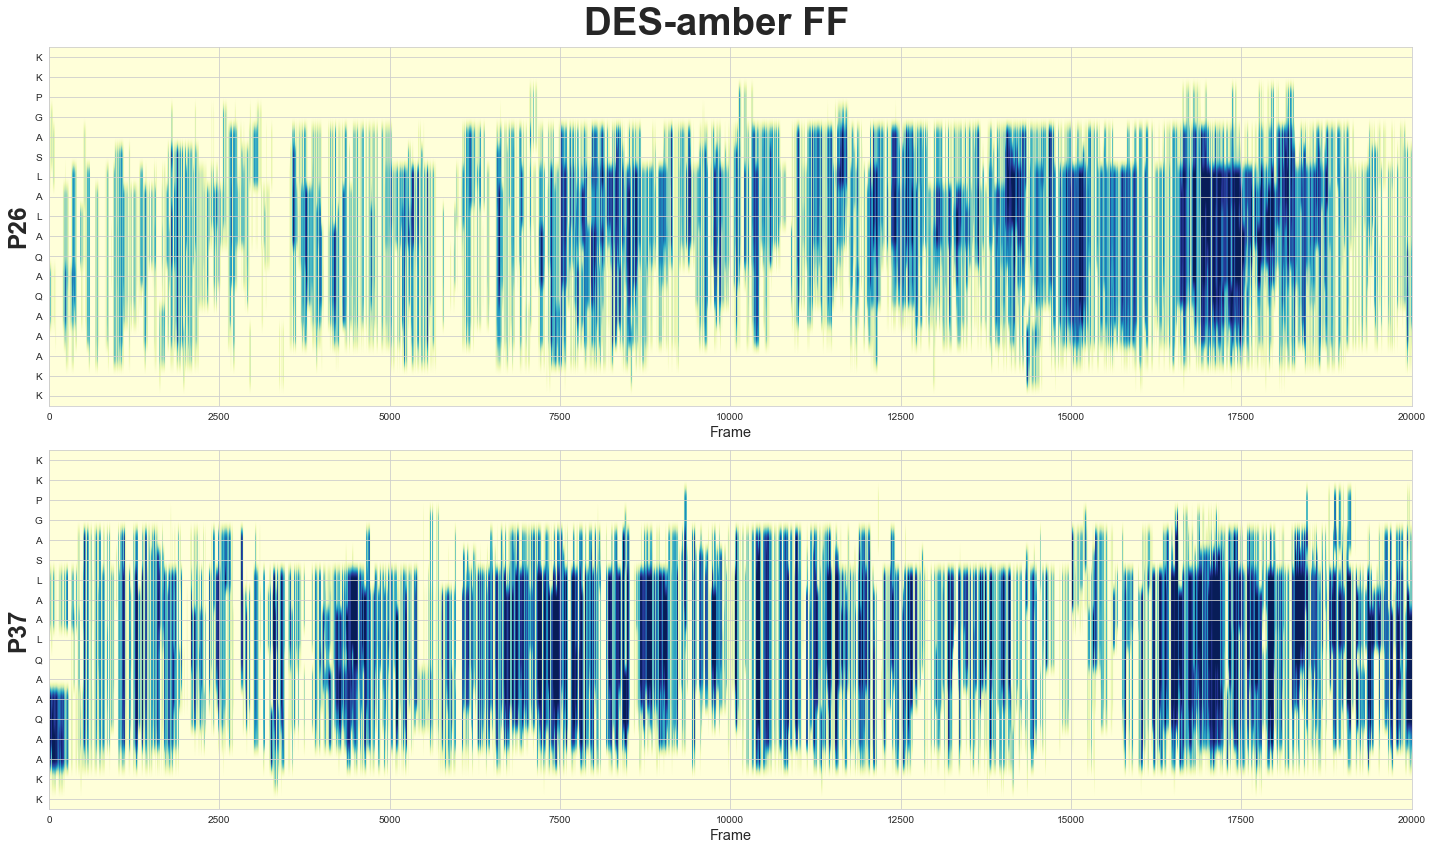

In [17]:
fig = plt.figure(figsize=(20, 12))
fig.suptitle("DES-amber FF", fontsize=38.5, fontweight="bold")
sns.set_style('whitegrid')


plt.subplot(211)
plt.imshow(helix["P26_DES-amber"].T, aspect='auto',cmap='YlGnBu')
plt.xlabel('Frame', fontsize=14.5)
plt.ylabel('P26',fontsize=24.5,fontweight="bold")
#plt.title("L4_Q12_a99SB-disp", fontsize=20.5)
#plt.colorbar(label='Helical fraction')
ticks=''.join([IUPACData.protein_letters_3to1[r.name.title()] for r in residues["P26_DES-amber"]])
plt.yticks(np.arange(helix["P26_DES-amber"].shape[1]), ticks)

plt.subplot(212)
plt.imshow(helix["P37_DES-amber"].T, aspect='auto',cmap='YlGnBu')
plt.xlabel('Frame',fontsize=14.5)
plt.ylabel('P37',fontsize=24.5,fontweight="bold")
#plt.title("A4_Q12_a99SB-disp",fontsize=20.5)
#plt.colorbar(label='Helical fraction')
ticks=''.join([IUPACData.protein_letters_3to1[r.name.title()] for r in residues["P37_DES-amber"]])
plt.yticks(np.arange(helix["P37_DES-amber"].shape[1]), ticks)


#cax = plt.axes([1.0, 0.040, 0.015, 0.90])
#plt.colorbar(label="Helical Fraction")
#plt.colorbar(label="Helical Fraction")
plt.tight_layout()

fig.savefig("/home/lourdes/Documents/Helical_Fraction_P26P37_DES-amber.png")

### Average Helicity

plot the average helicity. Error bars are not correct for short trajectories. They start having meaning when all the blocks used the calculate them are independent.

<ipython-input-19-9a6ebc586545>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


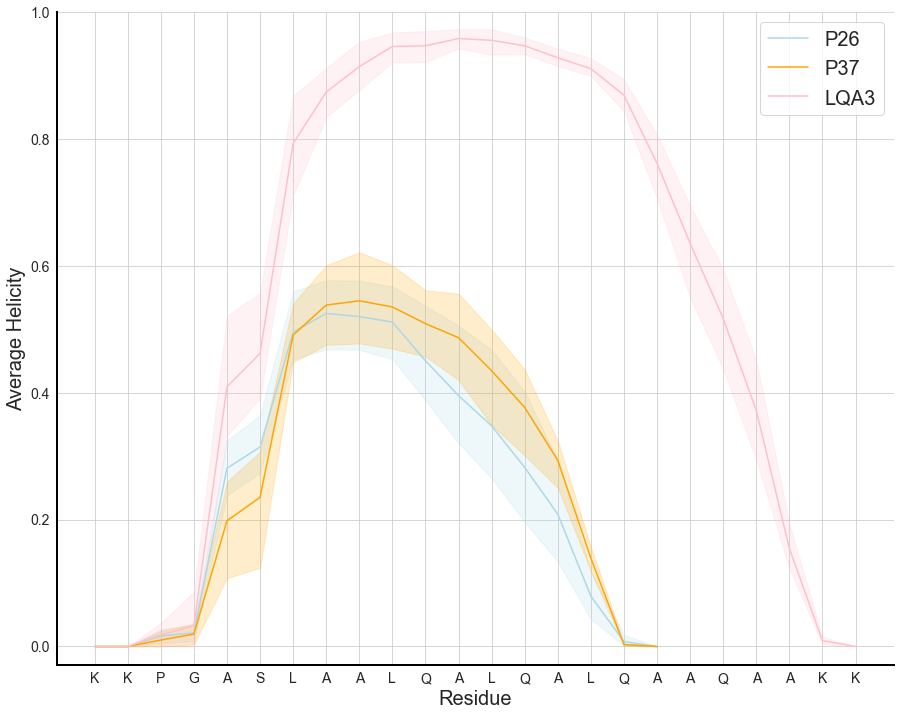

In [19]:
fig = plt.figure(figsize=(15, 12))

#fig.suptitle("a99SB-disp FF", fontsize=24.5, fontweight="bold")
plot_helicity(helix["P26_DES-amber"], residues["P26_DES-amber"], label="P26", color="lightblue" ,equil=7000)
plot_helicity(helix["P37_DES-amber"], residues["P37_DES-amber"], label="P37", color="orange" ,equil=7000)
plot_helicity(helix["LQA3_DES-amber"], residues["LQA3_DES-amber"], label="LQA3", color="pink" ,equil=7000)


ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=14)

fig.savefig("/home/lourdes/Documents/Helical_Average_P26P37_DES-amber.png")

<ipython-input-21-71be78e74470>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


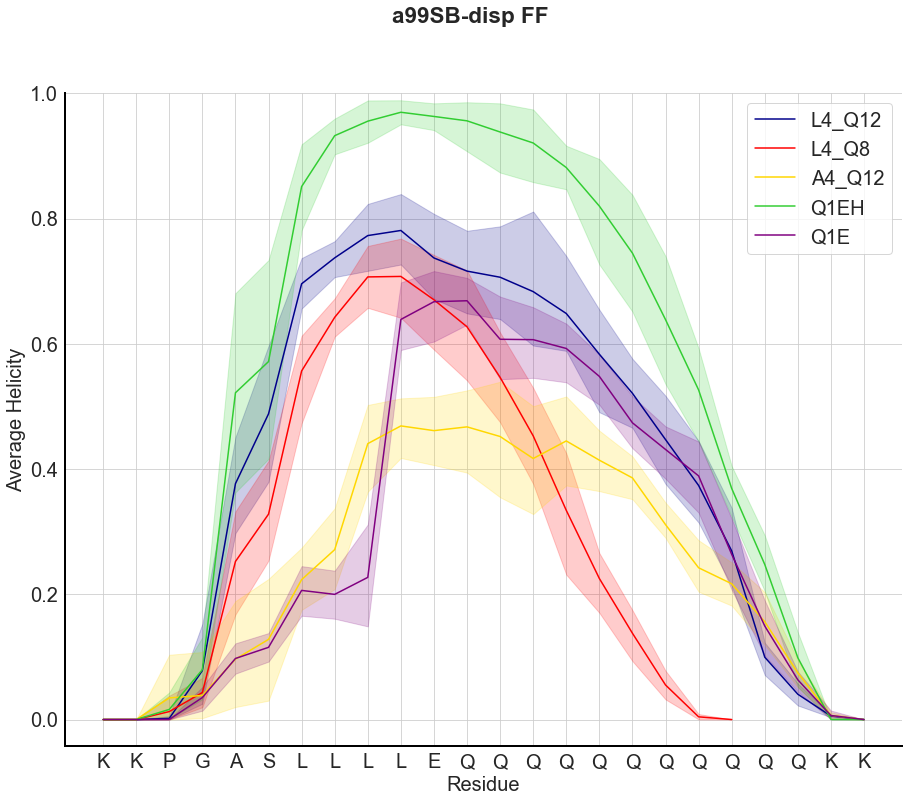

In [21]:
fig = plt.figure(figsize=(15, 12))
fig.suptitle("a99SB-disp FF", fontsize=22.5, fontweight="bold")
sns.set_style('whitegrid')

plot_helicity(helix['L4_Q12_a99SB-disp'], residues['L4_Q12_a99SB-disp'], label='L4_Q12', color="darkblue", equil=7000)
plot_helicity(helix['L4_Q8_a99SB-disp'], residues['L4_Q8_a99SB-disp'], label='L4_Q8', color="red", equil=7000)
plot_helicity(helix['A4_Q12_a99SB-disp'], residues['A4_Q12_a99SB-disp'], label='A4_Q12', color="gold", equil=7000)
plot_helicity(helix['Q1EH_a99SB-disp'], residues['Q1EH_a99SB-disp'], label='Q1EH', color="limegreen", equil=7000)
plot_helicity(helix['Q1E_a99SB-disp'], residues['Q1E_a99SB-disp'], label='Q1E', color="purple", equil=7000)
#plot_helicity(helix['LQA3_a99SB-disp'], residues['LQA3_a99SB-disp'], label='LQA3', color="pink", equil=7000)

ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=20)
fig.savefig("/home/lourdes/Documents/HelicityFF_a99SB-disp.png")


<ipython-input-22-bf50dc174338>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


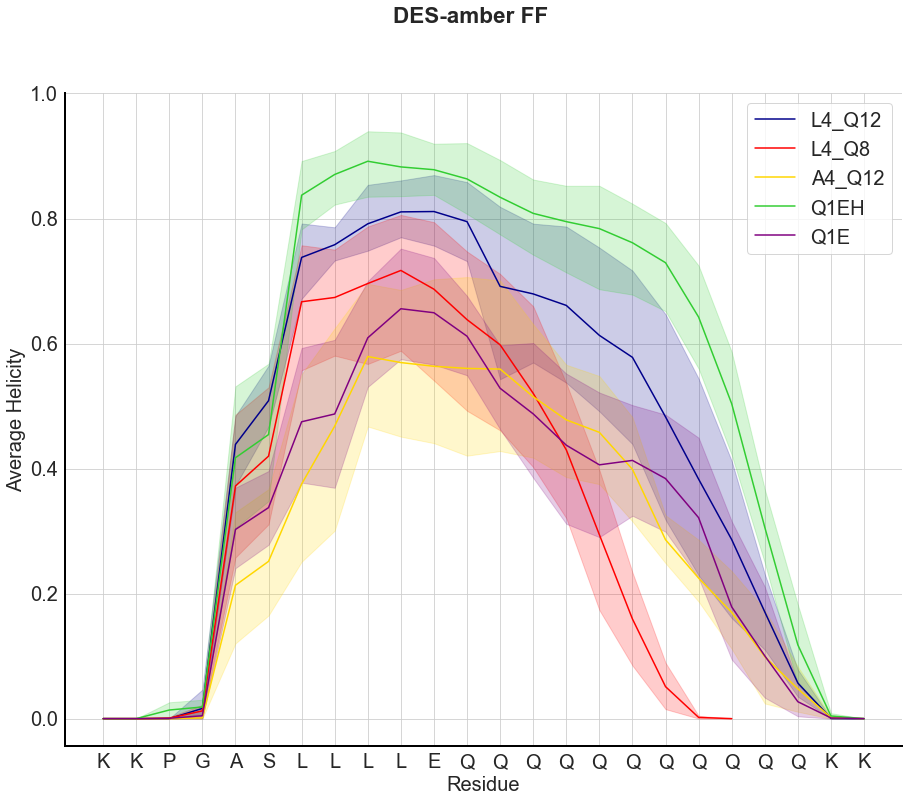

In [22]:
fig = plt.figure(figsize=(15, 12))
fig.suptitle("DES-amber FF", fontsize=22.5, fontweight="bold")
sns.set_style('whitegrid')

plot_helicity(helix['L4_Q12_DES-amber'], residues['L4_Q12_DES-amber'], label='L4_Q12', color="darkblue", equil=7000)
plot_helicity(helix['L4_Q8_DES-amber'], residues['L4_Q8_DES-amber'], label='L4_Q8', color="red", equil=7000)
plot_helicity(helix['A4_Q12_DES-amber'], residues['A4_Q12_DES-amber'], label='A4_Q12', color="gold", equil=7000)
plot_helicity(helix['Q1EH_DES-amber'], residues['Q1EH_DES-amber'], label='Q1EH', color="limegreen", equil=7000)
plot_helicity(helix['Q1E_DES-amber'], residues['Q1E_DES-amber'], label='Q1E', color="purple", equil=7000)
#plot_helicity(helix['LQA3_DES-amber'], residues['LQA3_DES-amber'], label='LQA3', color="pink", equil=7000)

ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=20)
fig.savefig("/home/lourdes/Documents/HelicityFF_DES-amber.png")

### Calculate the helicity average value for the Q1 residue 

#### We want to calculate the sc-mc L1-Q1 distance depending on the helicity prediction for Q1 residue

In [91]:
frequency_hbond={}
helicity_value={}
for name in helix: 
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{name}'
    helicity_value[name] = Q1_helicity (helix[name], residues[name], equil=7000)
    #print (name + " " + str(helicity_value))
    frequency_hbond[name]= scmchbond_freq(helix[name],residues[name],label=name,equil=7000, color=name)
    #print (frequency_hbond)
    
print(helicity_value)
print(frequency_hbond)


<mdtraj.Trajectory with 24283 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 412 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 411 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 412 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 18877 frames, 411 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>

<ipython-input-154-9c0a474bb0c7>:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


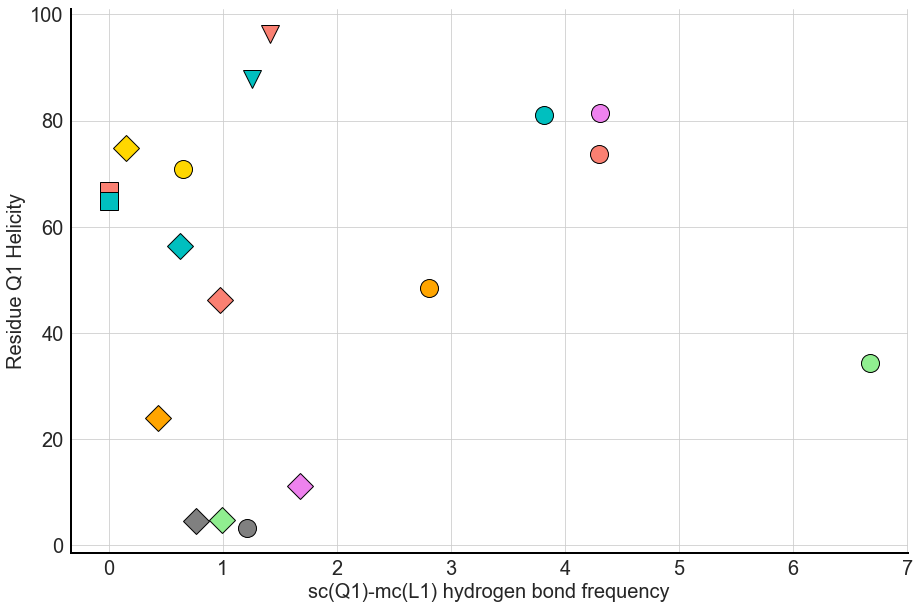

In [154]:
fig = plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
#plt.suptitle('Q1 Helicity correlation with sc-mc hbond frequency', fontsize=22)


plt.plot(frequency_hbond['L4_Q12_a99SB-disp'], helicity_value['L4_Q12_a99SB-disp'], label='L4_Q12_a99SB-disp', linestyle="none", markersize=18,markerfacecolor='salmon', markeredgecolor='black', marker="o")
plt.plot(frequency_hbond['A4_Q12_a99SB-disp'], helicity_value['A4_Q12_a99SB-disp'], label='A4_Q12_a99SB-disp', linestyle="none", markersize=18,markerfacecolor='salmon',markeredgecolor='black',marker="D")
plt.plot(frequency_hbond['Q1EH_a99SB-disp'], helicity_value['Q1EH_a99SB-disp'],label='Q1EH_a99SB-disp', linestyle="none", markersize=18,markerfacecolor='salmon',markeredgecolor='black',marker="v")
plt.plot(frequency_hbond['Q1E_a99SB-disp'], helicity_value['Q1E_a99SB-disp'], label='Q1E_a99SB-disp', linestyle="none", markersize=18,markerfacecolor='salmon',markeredgecolor='black',marker="s")

plt.plot(frequency_hbond['L4_Q12_DES-amber'], helicity_value['L4_Q12_DES-amber'], label='L4_Q12_DES-amber', linestyle="none", markersize=18,markerfacecolor='c',markeredgecolor='black',marker="o")
plt.plot(frequency_hbond['A4_Q12_DES-amber'], helicity_value['A4_Q12_DES-amber'], label='A4_Q12_DES-amber', linestyle="none", markersize=18,markerfacecolor='c',markeredgecolor='black',marker="D")
plt.plot(frequency_hbond['Q1EH_DES-amber'], helicity_value['Q1EH_DES-amber'], label='Q1EH_DES-amber', linestyle="none", markersize=18,markerfacecolor='c',markeredgecolor='black',marker="v")
plt.plot(frequency_hbond['Q1E_DES-amber'], helicity_value['Q1E_DES-amber'], label='Q1E_DES-amber', linestyle="none", markersize=18,markerfacecolor='c',markeredgecolor='black',marker="s")

plt.plot(frequency_hbond['L4_Q12_C36m'], helicity_value['L4_Q12_C36m'],label='L4_Q12_C36m', linestyle="none", markersize=18,markerfacecolor='lightgreen', markeredgecolor='black',marker="o")
plt.plot(frequency_hbond['A4_Q12_C36m'], helicity_value['A4_Q12_C36m'],label='A4_Q12_C36mr', linestyle="none", markersize=18,markerfacecolor='lightgreen',markeredgecolor='black',marker="D")

plt.plot(frequency_hbond['L4_Q12_aFB15'], helicity_value['L4_Q12_aFB15'], label='L4_Q12_aFB15', linestyle="none", markersize=18,markerfacecolor='gold',markeredgecolor='black',marker="o")
plt.plot(frequency_hbond['A4_Q12_aFB15'], helicity_value['A4_Q12_aFB15'],label='A4_Q12_aFB15', linestyle="none", markersize=18,markerfacecolor='gold',markeredgecolor='black',marker="D")

plt.plot(frequency_hbond['L4_Q12_ff15ipq'], helicity_value['L4_Q12_ff15ipq'],label='L4_Q12_ff15ipq', linestyle="none", markersize=18,markerfacecolor='grey',markeredgecolor='black',marker="o")
plt.plot(frequency_hbond['A4_Q12_ff15ipq'], helicity_value['A4_Q12_ff15ipq'],label='A4_Q12_ff15ipq', linestyle="none", markersize=18,markerfacecolor='grey',markeredgecolor='black',marker="D")

plt.plot(frequency_hbond['L4_Q12_A03ws'], helicity_value['L4_Q12_A03ws'], label='L4_Q12_A03ws',linestyle="none", markersize=18, markerfacecolor='violet',markeredgecolor='black',marker="o")
plt.plot(frequency_hbond['A4_Q12_A03ws'], helicity_value['A4_Q12_A03ws'],label='A4_Q12_A03ws', linestyle="none", markersize=18,markerfacecolor='violet',markeredgecolor='black',marker="D")

plt.plot(frequency_hbond['L4_Q12_RSFF'], helicity_value['L4_Q12_RSFF'],label='L4_Q12_RSFF', linestyle="none", markersize=18,markerfacecolor='orange',markeredgecolor='black',marker="o")
plt.plot(frequency_hbond['A4_Q12_RSFF'], helicity_value['A4_Q12_RSFF'],label='A4_Q12_RSFF', linestyle="none", markersize=18,markerfacecolor='orange',markeredgecolor='black',marker="D")

#handles =["lightcoral","deepskyblue","limegreen","gold","grey","purple","orange"]
#labels =["a99SB-disp","DES-amber","C36m","aFB15","ff15ipq","A03ws","RSFF"]

plt.ylabel('Residue Q1 Helicity', size=20)
plt.xlabel('sc(Q1)-mc(L1) hydrogen bond frequency', size=20)
#plt.xlim(0.0,0.20)
#plt.ylim(0,0.1)
#plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),markerscale=0.6)

ax = plt.axes()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)

ax.spines["bottom"].set_color("k")
ax.spines["left"].set_color("k")
ax.spines["right"].set_color("k")
ax.spines["top"].set_color("k")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=20)

fig.savefig("/home/lourdes/Documents/Q1hbondfreq.png")

### Distance histogram of the H side-chain and O main-chain of residue i-4 for L4Q12 and A4Q12 
    

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import statistics 

In [144]:
def hbond_freq (helix, residues, blocks=5, equil=0, **kwargs):
    helix = helix[equil:]
    H_bonds = calc_H_bonds(path, equil=0)           
    
    # the histogram of the data
    num_bins = 100
    (N, bins, patches) = plt.hist(H_bonds, bins=num_bins, label=name, density=True, alpha=0.5)
    frequency = list(N)
    #print (frequency)
    
    plt.axis([0,10,0,0.6])
    plt.xlabel('H-bond distances (A)')
    plt.ylabel('Probability')
    plt.title(r'Distance Histogram')
    plt.legend()
    sns.set_style('whitegrid')
    return frequency
   

<mdtraj.Trajectory with 24283 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 412 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 411 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 412 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 18877 frames, 411 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>

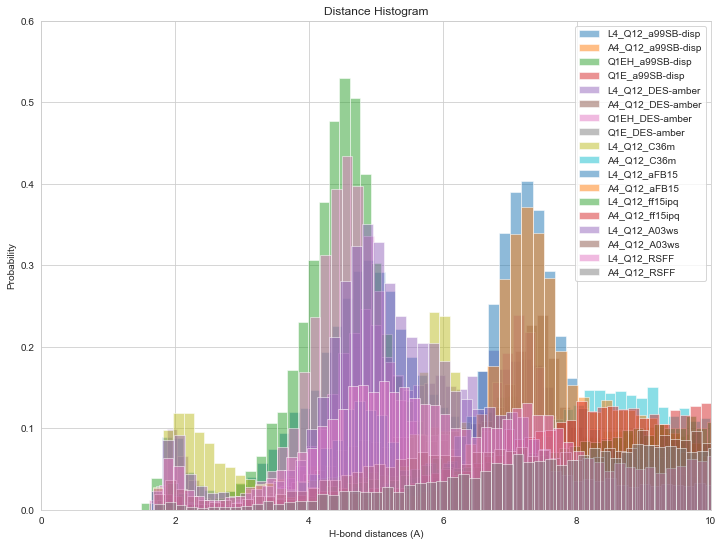

In [145]:
plt.figure(figsize=(12,9))

for name in helix: 
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{name}'
    hbond_freq(helix[name],residues[name],label=name,equil=7000, color=name)
    

In [555]:
def new_hbond_freq (helix, residues, blocks=5, equil=0, **kwargs):
    helicity_value = Q1_helicity (helix, residues, equil=7000)
    print (name + " " + str(helicity_value))

    H_bonds = calc_H_bonds(path, equil=0)  
    frecuencias, extremos = np.histogram(H_bonds, bins = 100)
    #print (frecuencias, extremos)
    #print (len(extremos))
    distance_values = []
    i = 0
    for i in range (len(extremos)-1): 
        new_value = (extremos[i]+extremos[i+1])/2
        distance_values.append(new_value)
        i + 1
    #print (distance_values)
    #print(len(distance_values))
    
    frequency_value = hbond_freq(helix,residues,equil=7000, label=name)
    
    final_frequency = []
    k = 0
    for k in range (len(frequency_value)):
        new_k = frequency_value[k]/helicity_value
        final_frequency.append(new_k)
        k = k + 1
        
    #print (final_frequency)
    #print (len (final_frequency))
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.bar(distance_values, final_frequency, label=name, alpha=0.5)
    ax.set_xlabel('L1-Q1 H-bond distance')
    ax.set_ylabel('Frequency')
    ax.set_title('sc-mc hydrogen bond distance')
    ax.legend()
    plt.axis([0,10,0,0.6])
    fig.tight_layout()

    plt.show()
    
    return distance_values, final_frequency

L4_Q12_DES-amber 0.8111538461538461
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>


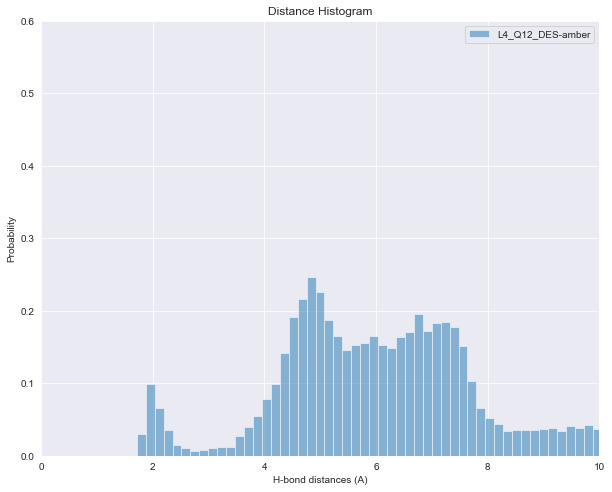

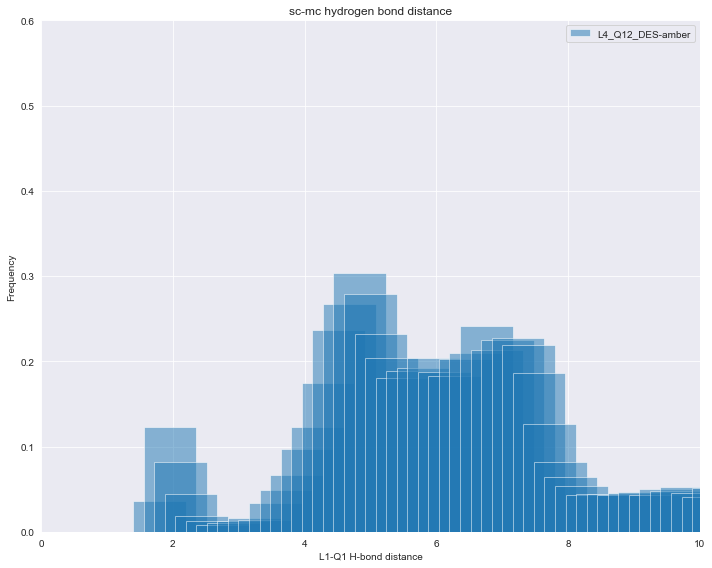

L4_Q12_C36m 0.34292307692307694
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 20001 frames, 413 atoms, 24 residues, and unitcells>


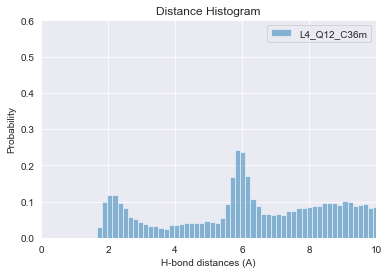

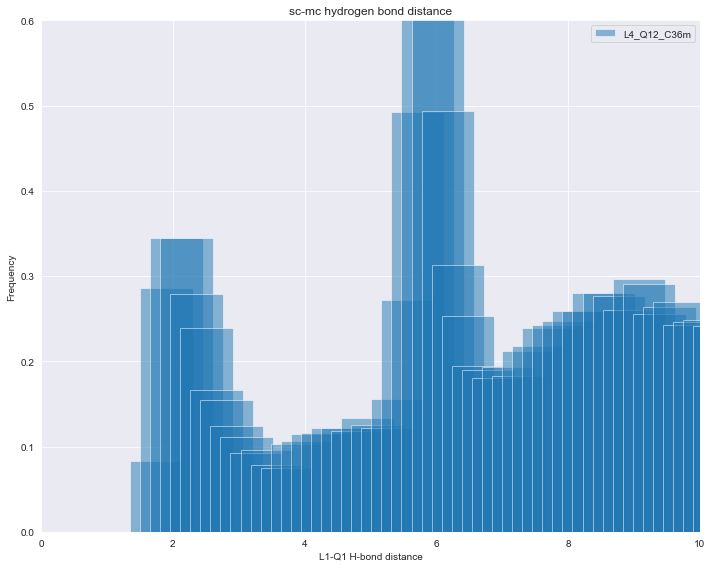

In [556]:
plt.figure(figsize=(10,8))
for name in helix: 
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{name}'
    new_hbond_freq(helix[name],residues[name],equil=7000,label=name)
    

### Dihedrals angles and Ramachandran plot

In [548]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB, GRO, XTC
from MDAnalysis.analysis import dihedrals
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

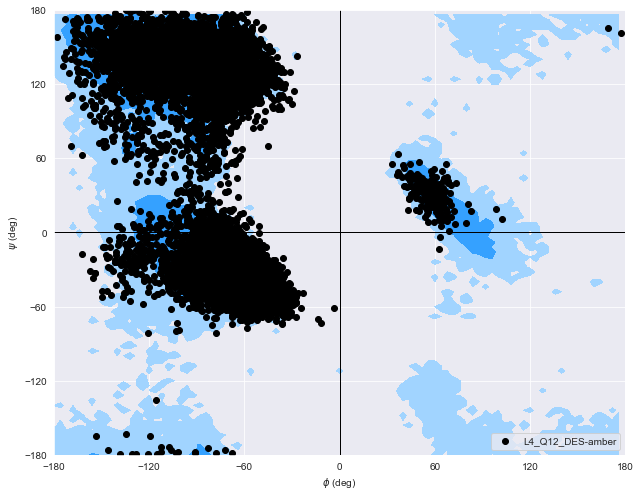

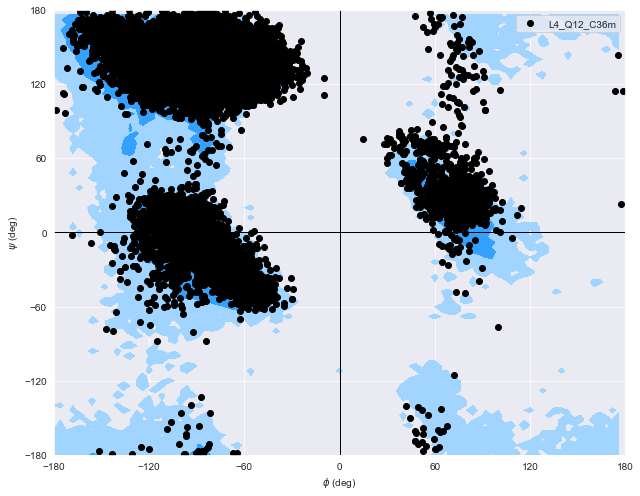

In [549]:

for system in system_list: 
    #path = f'/home/lourdes/MODULE6/data/{system}'
    temp = 1
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    topname = os.path.join(path, 'prot.pdb')
    trajname = os.path.join(path, f'prod{temp}_prot.xtc')
    u = mda.Universe(topname, trajname)
    r = u.select_atoms("resid 11")
    R = dihedrals.Ramachandran(r).run()
    
    fig, ax = plt.subplots(figsize=(9,7))
    R.plot(ax=ax, color='k', marker='o', ref=True, label=system)
    fig.tight_layout()
    plt.legend()


### Q1 Dihedrals angles and Janin plot

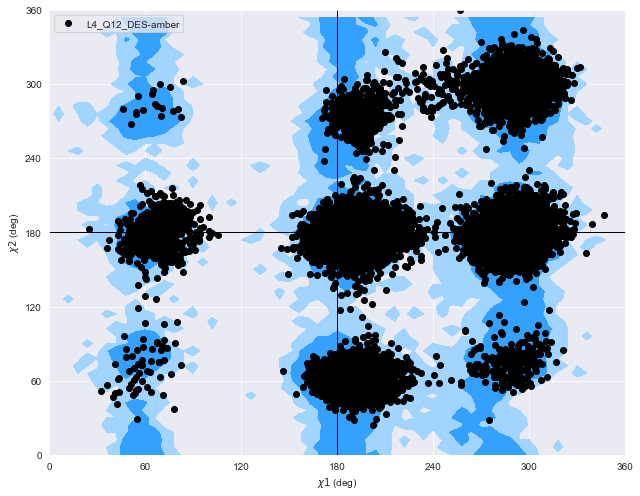

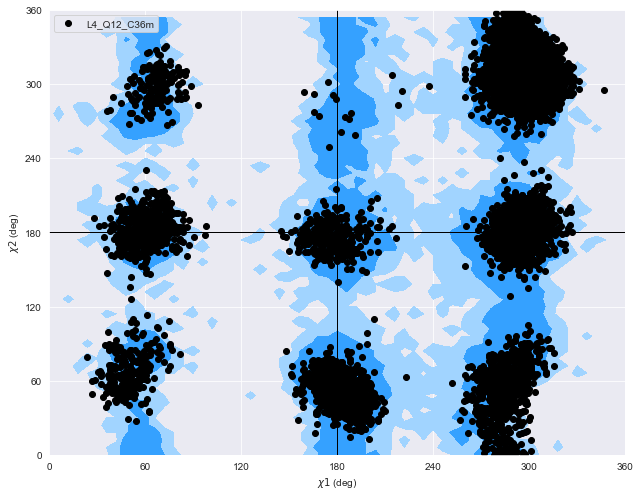

In [550]:

for system in system_list: 
    #path = f'/home/lourdes/MODULE6/data/{system}'
    temp = 1
    path = f'/home/lourdes/TFM-LOURDES/data/ALL/{system}'
    topname = os.path.join(path, 'prot.pdb')
    trajname = os.path.join(path, f'prod{temp}_prot.xtc')
    u = mda.Universe(topname, trajname)
    r = u.select_atoms("resid 11")
    J = dihedrals.Janin(r).run()
    
    fig, ax = plt.subplots(figsize=(9,7))
    J.plot(ax=ax, color='k', marker='o', ref=True, label=system)
    fig.tight_layout()
    plt.legend()
